# Constrained Optimization

In [1]:
from scipy import optimize

import matplotlib.pyplot as plt
import numpy as np
import sympy

sympy.init_printing()

Constraints add another level of complexity to optimization problems, and they require a classification of their own. A simple form of constrained optimization is the optimization where the coordinate variables are subject to some bounds.

For example: $min_x f(x)$ subject to $0 ≤ x ≤ 1$

The constraint $0 ≤ x ≤ 1$ is simple because it only restricts the range of the coordinate without dependencies on the other variables

This type of problems can be solved using the *L-BFGS-B* method in SciPy, which is a variant of the BFGS method we
used earlier. This solver is available through the function `optimize.fmin_l_bgfs_b` or via `optimize.minimize` with the method argument set to 'L-BFGS-B'

### As an example of solving a bounded optimization problem with the *L-BFGS-B* solver

Consider minimizing the objective function:

$f(x) = (x_1 − 1)^2 − (x_2 − 1)^2$ subject to the constraints $2 ≤ x_1 ≤ 3$ and $0 ≤ x_2 ≤ 2$

> Contours of the objective function $f(x)$, with the unconstrained (blue star) and constrained minima (red star). The feasible region of the constrained problem is shaded in gray

In [2]:
def func_X_Y_to_XY(f, X, Y):
    """
    Wrapper for f(X, Y) -> f([X, Y])
    """
    s = np.shape(X)
    # ravel return a contiguous flattened array
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

In [3]:
def f(X):
    x, y = X
    return (x - 1)**2 + (y - 1)**2

x_opt = optimize.minimize(f, [1, 1], method='BFGS').x

# Real optima
x_opt

array([1., 1.])

In [4]:
# x1 and x2 boundaries
bnd_x1, bnd_x2 = (2, 3), (0, 2)

In [5]:
x_cons_opt = optimize.minimize(f, [1, 1], method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]).x

# Constrained optima
x_cons_opt

array([2., 1.])

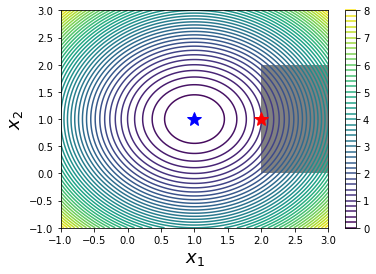

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)

c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

# Plot the boundaries by grey color
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0], facecolor="grey")

ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

Constraints that are defined by equalities or inequalities that include more than
one variable are somewhat more complicated to deal with. However, there are general
techniques also for this type of problems. For example, using the Lagrange multipliers, it
is possible to convert a constrained optimization problem to an unconstrained problem
by introducing additional variables

For example, consider the optimization problem $min_x f(x)$ subject to the equality constraint $g(x) = 0$. In an unconstrained optimization
problem, the gradient of $f(x)$ vanishes at the optimal points, $\nabla f(x)=0$. It can be shown that the corresponding condition for constrained problems is that the negative gradient lies in the space supported by the constraint normal, i.e., $-\nabla f(x) = \lambda J_g^T (x)$. Here $J_g(x)$ is the Jacobian matrix of the constraint function $g(x)$ and λ is the vector of Lagrange multipliers (new variables).

This condition arises from equating to zero the gradient of the function $Λ(x, λ) = f(x) + λT_g(x)$, which is known as the Lagrangian function. Therefore,
if both $f(x)$ and $g(x)$ are continuous and smooth, a stationary point $(x_0, λ_0)$ of the function $Λ(x, λ)$ corresponds to an $x_0$ that is an optimum of the original constrained optimization problem. Note that if $g(x)$ is a scalar function (i.e., there is only one constraint), then the Jacobian $J_g(x)$ reduces to the gradient $\nabla g(x)$

To illustrate this technique, consider the problem of maximizing the volume of a rectangle with sides of length $x_1$, $x_2$, and $x_3$, subject to the constraint that the total surface area should be unity: $g(x) = 2x_1x_2+2x_0x_2+2x_1x_0 − 1 = 0$. To solve this optimization problem using Lagrange multipliers, we form the Lagrangian $Λ(x) = f(x)+λg(x)$ and seek the stationary points for $\nabla Λ(x) = 0$. With SymPy, we can carry out this task by first defining
the symbols for the variables in the problem, then constructing expressions for $f(x)$, $g(x)$, and $Λ(x)$

In [10]:
x = x0, x1, x2, l = sympy.symbols("x_0, x_1, x_2, lambda")

# rectangle volume
f = x0 * x1 * x2

g = 2 * (x1 * x2 + x0 * x2 + x1 * x0) - 1

L = f + l * g

f, g, L

In [11]:
# Find the gradient
grad_L = [sympy.diff(L, x_) for x_ in x]
grad_L

solving the equation $\nabla Λ(x)=0$ using `sympy.solve`

In [12]:
# Solve equation and find Lagrangian
sols = sympy.solve(grad_L)
sols

#### Substitute solutions to the constraint function $g(x)$

In [14]:
g.subs(sols[0])

In [15]:
f.subs(sols[0])

> To solve the full problem numerically using SciPy’s SLSQP solver, we need to define
Python functions for the objective function and the constraint function

In [16]:
def f(X):
    return -X[0] * X[1] * X[2]

def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

#### Note that since the SciPy optimization functions solve minimization problems, and here we are interested in maximization, the function $f$ is here the negative of the original objective function. Next we define the constraint dictionary for $g(x) = 0$ and finally call the `optimize.minimize` function

In [18]:
constraint = dict(type='eq', fun=g)
result = optimize.minimize(f, [0.5, 1, 1.5], method='SLSQP', constraints=[constraint])
result

     fun: -0.06804136862287297
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.40824188, 0.40825127, 0.40825165])

In [20]:
argmin = result.x
argmin

array([0.40824188, 0.40825127, 0.40825165])

> To solve problems with inequality constraints, all we need to do is to set `type='ineq'` in the constraint dictionary and provide the corresponding inequality function. To demonstrate minimization of a nonlinear objective function with a nonlinear inequality constraint, we return to the quadratic problem considered previously but in this case with inequality constraint $g(x) = x_1 − 1.75 − (x_0 − 0.75)^4 ≥ 0$. As usual, we begin by defining the objective function and the constraint function, as well as the constraint dictionary

In [21]:
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2

def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

constraints = [dict(type='ineq', fun=g)]

> Next, we are ready to solve the optimization problem by calling the `optimize.minimize` function. For comparison, here we also solve the corresponding unconstrained problem.

In [38]:
x_opt = optimize.minimize(f, (0, 0), method='BFGS').x

# Put some constraint
x_cons_opt = optimize.minimize(f, (0, 0), method='SLSQP', constraints=constraints).x

> Contour plot of the objective function with the feasible region of the constrained problem shaded gray. The red and blue stars are the optimal points in
the constrained and unconstrained problems, respectively

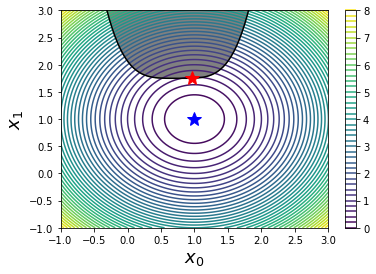

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)

X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)

# scale y-axis
ax.set_ylim(-1, 3)

# Constraint
ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
# Fill the constraint area in the plot
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color='grey')

# x_opt - without constraint
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

# Mark by red star x_cons_opt - optimum with constraint
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

# Set labels for axis
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)

# Add colorbar for better understanding of the data
plt.colorbar(c, ax=ax)

For optimization problems with only inequality constraints, `SciPy` provides an alternative solver using the constrained optimization by linear approximation *(COBYLA)* method. This solver is accessible either through `optimize.fmin_cobyla` or `optimize.minimize` with `method='COBYLA'`. The previous example could just as well have been solved with this solver, by replacing `method='SLSQP'` with `method='COBYLA'`.